In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datasets import Dataset, DatasetDict

from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

import torch
#from sentence_transformers import SentenceTransformer, InputExample, losses, models, evaluation
from torch.utils.data import DataLoader
#from sentence_transformers import LoggingHandler
#from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
import logging
import numpy as np
import re

#from sklearn.metrics import roc_curve, auc

from tqdm.auto import tqdm
from tqdm.notebook import tqdm
from transformers import AutoModel, AutoTokenizer
from sklearn.metrics import roc_curve, auc


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_folder = "C:\\Users\\gckc1\\My Drive\\My programs\\Sierra\\full_auto_review_data\\20240115_for_model_training"
model_folder = "C:\\Users\\gckc1\\My Drive\\My programs\\Sierra\\model_training"
review_data_folder = "C:\\Users\\gckc1\\My Drive\\My programs\\Sierra\\review_list"


In [2]:
val_file_location = "20240417_val_set.csv"
val_file = pd.read_csv(data_folder + "\\" + val_file_location)

dev_file_location = "20240417_dev_set_shuffled.csv"
dev_file = pd.read_csv(data_folder + "\\" + dev_file_location)

val_heart_file_location = "20240417_val_heart_set.csv"
val_heart_file = pd.read_csv(data_folder + "\\" + val_heart_file_location) 

val_HIV_file_location = "20240417_val_HIV_set.csv"
val_HIV_file = pd.read_csv(data_folder + "\\" + val_HIV_file_location) 

In [3]:
recode_dict = {0:0, 0.6:0.5, 1:1}
dev_file["label"] = dev_file["label"].replace(recode_dict)
val_file["label"] = val_file["label"].replace(recode_dict)
val_heart_file["label"] = val_heart_file["label"].replace(recode_dict)
val_HIV_file["label"] = val_HIV_file["label"].replace(recode_dict)



In [4]:
dev_file["obj_sel"] = dev_file["obj_sel"].str.replace(r'^\[OA\]', '', regex=True)
dev_file["tit_abs"] = dev_file["tit_abs"].str.replace(r'^ \[OA\]', '', regex=True)

val_file["obj_sel"] = val_file["obj_sel"].str.replace(r'^\[OA\]', '', regex=True)
val_file["tit_abs"] = val_file["tit_abs"].str.replace(r'^ \[OA\]', '', regex=True)

val_heart_file["obj_sel"] = val_heart_file["obj_sel"].str.replace(r'^\[OA\]', '', regex=True)
val_heart_file["tit_abs"] = val_heart_file["tit_abs"].str.replace(r'^ \[OA\]', '', regex=True)

val_HIV_file["obj_sel"] = val_HIV_file["obj_sel"].str.replace(r'^\[OA\]', '', regex=True)
val_HIV_file["tit_abs"] = val_HIV_file["tit_abs"].str.replace(r'^ \[OA\]', '', regex=True)

dev_file["obj_sel"] = dev_file["obj_sel"].str.replace(r'^\[BG\]', ' [BG] ', regex=True)
val_file["obj_sel"] = val_file["obj_sel"].str.replace(r'^\[BG\]', ' [BG] ', regex=True)
val_heart_file["obj_sel"] = val_heart_file["obj_sel"].str.replace(r'^\[BG\]', ' [BG] ', regex=True)
val_HIV_file["obj_sel"] = val_HIV_file["obj_sel"].str.replace(r'^\[BG\]', ' [BG] ', regex=True)

In [5]:
val_file["obj_sel"][0]

' [BG] Abdominal decompression was developed as a means of pain relief during labour. It has also been used for complications of pregnancy, and in healthy pregnant women in an attempt to improve fetal wellbeing and intellectual development. [OBJ] The objective of this review was to assess the effects of antenatal abdominal decompression for maternal hypertension or impaired fetal growth, on perinatal outcome. [SEL] Randomised or quasi‐randomised trials comparing abdominal decompression with no decompression in women with pre‐eclampsia and/or fetuses thought to be compromised.'

In [6]:
dev_file["obj_sel"] = "[RTI] " + dev_file["Review_Title"] + " [OBJ] " + dev_file["Objective"].fillna("") + " [SEL] " + dev_file["Selection_criteria"].fillna("")



In [7]:
dev_file["obj_sel"][0]

'[RTI] Single‐dose intravenous ketorolac for acute postoperative pain in adults [OBJ] To assess the analgesic efficacy and adverse effects of single‐dose intravenous ketorolac, compared with placebo or an active comparator, for moderate to severe postoperative pain in adults. [SEL] Randomized double‐blind trials that compared a single postoperative dose of intravenous ketorolac with placebo or another active treatment, for treating acute postoperative pain in adults following any surgery.'

In [8]:
dev_file_1 = dev_file[0:100000].copy()
dev_file_2 = dev_file[100000:200000].copy()
dev_file_3 = dev_file[200000:300000].copy()
dev_file_4 = dev_file[300000:466975].copy()
#val_file = val_file.sample(10000).copy()
#val_file = val_file.sample(5000).copy()

In [9]:
dev_set_1 = Dataset.from_pandas(dev_file_1)
dev_set_2 = Dataset.from_pandas(dev_file_2)
dev_set_3 = Dataset.from_pandas(dev_file_3)
dev_set_4 = Dataset.from_pandas(dev_file_4)

In [3]:
model_ckpt = "dmis-lab/biobert-large-cased-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

In [4]:
new_tokens = ["[RIT]", "[OBJ]", "[SEL]", "[TIT]", "[ABS]"]
num_added_toks = tokenizer.add_tokens(new_tokens)

In [5]:
# Check if the new tokens are in the tokenizer
for token in new_tokens:
    if token in tokenizer.get_vocab():
        print(f"Token {token} is in the vocabulary.")
    else:
        print(f"Token {token} is not in the vocabulary.")

# Check the size of the new embeddings
print(f"New embedding size: {model.get_input_embeddings().num_embeddings}")

model.resize_token_embeddings(len(tokenizer))

Token [RIT] is in the vocabulary.
Token [OBJ] is in the vocabulary.
Token [SEL] is in the vocabulary.
Token [TIT] is in the vocabulary.
Token [ABS] is in the vocabulary.
New embedding size: 58996


Embedding(59001, 1024)

In [13]:
def token(df_input):
    df = Dataset.from_pandas(df_input.copy())
    for part in ["obj_sel", "tit_abs"]:
        df = df.map(
            lambda x:  tokenizer(
                x[part], max_length = 512, padding = True, truncation = True
            ), batched = True, batch_size = None
        )
        for col in ['input_ids', 'attention_mask']:
            df = df.rename_column(
                col, part+"_"+col
            )
    return(df)

In [14]:
dev_set_1 = token(dev_file_1)
dev_set_2 = token(dev_file_2)
dev_set_3 = token(dev_file_3)
dev_set_4 = token(dev_file_4)

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/166975 [00:00<?, ? examples/s]

Map:   0%|          | 0/166975 [00:00<?, ? examples/s]

In [15]:
all_cols = ['label', 'obj_sel_input_ids', 'obj_sel_attention_mask', 'tit_abs_input_ids', 'tit_abs_attention_mask']


In [16]:
tmp1 = dev_set_1.to_pandas()
tmp2 = dev_set_2.to_pandas()
tmp3 = dev_set_3.to_pandas()
tmp4 = dev_set_4.to_pandas()

tmp = pd.concat([tmp1, tmp2, tmp3, tmp4], ignore_index = True)



In [19]:
dev_set = Dataset.from_pandas(tmp)

In [20]:
dev_set.set_format(type = 'torch', columns = all_cols)

In [21]:
batch_size = 32
loader = torch.utils.data.DataLoader(
    dev_set, batch_size=batch_size, shuffle = True)

In [22]:
def mean_pool(token_embeds, attention_mask):
    in_mask = attention_mask.unsqueeze(-1).expand(token_embeds.size()).float()
    pool = torch.sum(token_embeds * in_mask, 1) / torch.clamp(
        in_mask.sum(1), min=1e-9
    )
    return pool
    

In [23]:
ffnn = torch.nn.Linear(1024*3, 1)

In [24]:
loss_func = torch.nn.MSELoss()

In [25]:
from transformers.optimization import get_linear_schedule_with_warmup

optim = torch.optim.Adam(model.parameters(), lr = 2e-5)
total_steps = int(len(dev_set) / batch_size)
warmup_steps = 500
scheduler = get_linear_schedule_with_warmup(
    optim, num_warmup_steps=warmup_steps,
    num_training_steps=total_steps - warmup_steps
)




In [26]:
import torch.nn as nn

model = nn.DataParallel(model)
ffnn = nn.DataParallel(ffnn)

In [27]:
model = model.to(device)
ffnn = ffnn.to(device)

In [28]:
for epoch in range(1):
    model.train()
    loop = tqdm(loader, leave= True)
    for batch in loop:
        optim.zero_grad()
        inputs_ids_a = batch['obj_sel_input_ids'].to(device)
        inputs_ids_b = batch['tit_abs_input_ids'].to(device)
        attention_a = batch['obj_sel_attention_mask'].to(device)
        attention_b = batch['tit_abs_attention_mask'].to(device)
        label = batch['label'].to(device)
        u = model(inputs_ids_a, attention_mask = attention_a)[0]
        v = model(inputs_ids_b, attention_mask = attention_b)[0]
        u = mean_pool(u, attention_a)
        v = mean_pool(v, attention_b)
        uv = torch.sub(u, v)
        uv_abs = torch.abs(uv)
        x = torch.cat([u, v, uv_abs], dim = -1)
        x = ffnn(x)
        x = x.squeeze()
        loss = loss_func(x, label)
        loss.backward()
        optim.step()
        scheduler.step()
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

  0%|          | 0/14593 [00:00<?, ?it/s]

C:\Users\gckc1\anaconda3\envs\Sierra\Lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn("PyTorch is not compiled with NCCL support")


In [29]:
torch.save(model, model_folder + "\\20240424_biobert_relevance_title_obj_sel\\" + '20240424_biobert_relevance.pth')
torch.save(ffnn, model_folder + "\\20240424_biobert_relevance_title_obj_sel\\" + '20240424_ffnn_relevance.pth')

In [ ]:
####################################################################

In [6]:
val_1_file_location = "20240419_val_1_rti_bg_obj_sel_output.csv"
val_1_file = pd.read_csv(data_folder + "\\" + val_1_file_location)

val_2_file_location = "20240419_val_2_rti_bg_obj_sel_output.csv"
val_2_file = pd.read_csv(data_folder + "\\" + val_2_file_location)

val_heart_file_location = "20240419_val_heart_rti_bg_obj_sel_output.csv"
val_heart_file = pd.read_csv(data_folder + "\\" + val_heart_file_location) 

val_HIV_file_location = "20240419_val_HIV_rti_bg_obj_sel_output.csv"
val_HIV_file = pd.read_csv(data_folder + "\\" + val_HIV_file_location) 

In [7]:
val_HIV_file = val_HIV_file.drop(['obj_sel_input_ids', 'token_type_ids', "obj_sel_attention_mask", "tit_abs_input_ids","tit_abs_attention_mask", "Outputs", "Actual Labels"], axis=1).copy()
val_heart_file = val_heart_file.drop(['obj_sel_input_ids', 'token_type_ids', "obj_sel_attention_mask", "tit_abs_input_ids","tit_abs_attention_mask", "Outputs", "Actual Labels"], axis=1).copy()
val_1_file = val_1_file.drop(['obj_sel_input_ids', 'token_type_ids', "obj_sel_attention_mask", "tit_abs_input_ids","tit_abs_attention_mask", "Outputs", "Actual Labels"], axis=1).copy()
val_2_file = val_2_file.drop(['obj_sel_input_ids', 'token_type_ids', "obj_sel_attention_mask", "tit_abs_input_ids","tit_abs_attention_mask", "Outputs", "Actual Labels"], axis=1).copy()

In [8]:
val_1_file["obj_sel"] = "[RTI] " + val_1_file["Review_Title"] + " [OBJ] " + val_1_file["Objective"].fillna("") + " [SEL] " + val_1_file["Selection_criteria"].fillna("")
val_2_file["obj_sel"] = "[RTI] " + val_2_file["Review_Title"] + " [OBJ] " + val_2_file["Objective"].fillna("") + " [SEL] " + val_2_file["Selection_criteria"].fillna("")
val_heart_file["obj_sel"] = "[RTI] " + val_heart_file["Review_Title"] + " [OBJ] " + val_heart_file["Objective"].fillna("") + " [SEL] " + val_heart_file["Selection_criteria"].fillna("")
val_HIV_file["obj_sel"] = "[RTI] " + val_HIV_file["Review_Title"] + " [OBJ] " + val_HIV_file["Objective"].fillna("") + " [SEL] " + val_HIV_file["Selection_criteria"].fillna("")

In [9]:
len(val_heart_file)

19069

In [10]:
val_1_set = Dataset.from_pandas(val_1_file)
val_2_set = Dataset.from_pandas(val_2_file)
val_heart_set = Dataset.from_pandas(val_heart_file)
val_HIV_set = Dataset.from_pandas(val_HIV_file)

In [11]:
model_ckpt = "dmis-lab/biobert-large-cased-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

new_tokens = ["[RIT]", "[OBJ]", "[SEL]", "[TIT]", "[ABS]"]
num_added_toks = tokenizer.add_tokens(new_tokens)

In [12]:
def token(df_input):
    df = Dataset.from_pandas(df_input.copy())
    for part in ["obj_sel", "tit_abs"]:
        df = df.map(
            lambda x:  tokenizer(
                x[part], max_length = 512, padding = True, truncation = True
            ), batched = True, batch_size = None
        )
        for col in ['input_ids', 'attention_mask']:
            df = df.rename_column(
                col, part+"_"+col
            )
    return(df)

In [13]:
val_HIV_set = token(val_HIV_file)
val_1_set = token(val_1_file)
val_2_set = token(val_2_file)
val_heart_set = token(val_heart_file)

Map:   0%|          | 0/4400 [00:00<?, ? examples/s]

Map:   0%|          | 0/4400 [00:00<?, ? examples/s]

Map:   0%|          | 0/26892 [00:00<?, ? examples/s]

Map:   0%|          | 0/26892 [00:00<?, ? examples/s]

Map:   0%|          | 0/27051 [00:00<?, ? examples/s]

Map:   0%|          | 0/27051 [00:00<?, ? examples/s]

Map:   0%|          | 0/19069 [00:00<?, ? examples/s]

Map:   0%|          | 0/19069 [00:00<?, ? examples/s]

In [15]:
all_cols = ['label', 'obj_sel_input_ids', 'obj_sel_attention_mask', 'tit_abs_input_ids', 'tit_abs_attention_mask']


In [16]:
val_1_set.set_format(type = 'torch', columns = all_cols)
val_2_set.set_format(type = 'torch', columns = all_cols)
val_heart_set.set_format(type = 'torch', columns = all_cols)
val_HIV_set.set_format(type = 'torch', columns = all_cols)

In [18]:
from torch.utils.data import DataLoader
val_1_loader = DataLoader(val_1_set, batch_size = 64, shuffle = False)
val_2_loader = DataLoader(val_2_set, batch_size = 64, shuffle = False)
val_heart_loader = DataLoader(val_heart_set, batch_size = 64, shuffle = False)
val_HIV_loader = DataLoader(val_HIV_set, batch_size = 64, shuffle = False)

In [19]:
model = torch.load(model_folder + "\\20240424_biobert_relevance_title_obj_sel\\" + '20240424_biobert_relevance.pth')
ffnn = torch.load(model_folder + "\\20240424_biobert_relevance_title_obj_sel\\" + '20240424_ffnn_relevance.pth')
model = model.to(device)
ffnn = ffnn.to(device)
loss_func = torch.nn.MSELoss()

def mean_pool(token_embeds, attention_mask):
    in_mask = attention_mask.unsqueeze(-1).expand(token_embeds.size()).float()
    pool = torch.sum(token_embeds * in_mask, 1) / torch.clamp(
        in_mask.sum(1), min=1e-9
    )
    return pool

In [20]:
def evaluate_model(model, ffnn, data_loader, device):
    model.eval()
    ffnn.eval()
    all_outputs = []
    predictions = []
    all_labels = []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating", leave = True):
            inputs_ids_a = batch['obj_sel_input_ids'].to(device)
            inputs_ids_b = batch['tit_abs_input_ids'].to(device)
            attention_a = batch['obj_sel_attention_mask'].to(device)
            attention_b = batch['tit_abs_attention_mask'].to(device)
            labels = batch['label'].to(device)

            u = model(inputs_ids_a, attention_mask = attention_a)[0]
            v = model(inputs_ids_b, attention_mask = attention_b)[0]
            u = mean_pool(u, attention_a)
            v = mean_pool(v, attention_b)
            uv = torch.sub(u, v)
            uv_abs = torch.abs(uv)
            outputs = torch.cat([u, v, uv_abs], dim= -1)
            outputs = ffnn(outputs)
            
            all_labels.extend(labels.cpu().numpy())
            all_outputs.append(outputs.cpu().numpy())
    all_outputs = np.vstack(all_outputs)
    return all_labels, all_outputs

In [21]:
val_1_labels, val_1_outputs = evaluate_model(model, ffnn, val_1_loader, device)
val_2_labels, val_2_outputs = evaluate_model(model, ffnn, val_2_loader, device)
val_heart_labels, val_heart_outputs = evaluate_model(model, ffnn, val_heart_loader, device)
val_HIV_labels, val_HIV_outputs = evaluate_model(model, ffnn, val_HIV_loader, device)


Evaluating:   0%|          | 0/421 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/298 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?it/s]

In [22]:
val_1_outputs = val_1_outputs.squeeze()
val_2_outputs = val_2_outputs.squeeze()
val_heart_outputs = val_heart_outputs.squeeze()
val_HIV_outputs = val_HIV_outputs.squeeze()

In [23]:
def summary_stats(labels, outputs):
    predictions_df = pd.DataFrame({
        'Outputs': outputs,
        'Actual Labels': labels
    })
    print(predictions_df["Actual Labels"].value_counts())
    grouped_stats = predictions_df.groupby("Actual Labels")["Outputs"].describe()
    print(grouped_stats)

In [24]:
summary_stats(val_1_labels, val_1_outputs)

Actual Labels
0.0    12425
0.5     9922
1.0     4545
Name: count, dtype: int64
                 count      mean       std       min       25%       50%  \
Actual Labels                                                              
0.0            12425.0  0.061551  0.161985 -0.133288 -0.017249 -0.001651   
0.5             9922.0  0.509090  0.217379 -0.045466  0.378661  0.563257   
1.0             4545.0  0.661780  0.137649 -0.008959  0.606088  0.684855   

                    75%       max  
Actual Labels                      
0.0            0.041980  0.934999  
0.5            0.677382  0.966197  
1.0            0.748084  1.045554  


In [25]:
summary_stats(val_2_labels, val_2_outputs)

Actual Labels
0.0    13020
0.5     9448
1.0     4583
Name: count, dtype: int64
                 count      mean       std       min       25%       50%  \
Actual Labels                                                              
0.0            13020.0  0.076840  0.176334 -0.125571 -0.015998  0.001942   
0.5             9448.0  0.524553  0.212873 -0.047469  0.405040  0.573849   
1.0             4583.0  0.669878  0.131563 -0.021896  0.606583  0.689442   

                    75%       max  
Actual Labels                      
0.0            0.068159  1.005301  
0.5            0.685581  0.977589  
1.0            0.758503  0.968993  


In [26]:
summary_stats(val_heart_labels, val_heart_outputs)

Actual Labels
0.5    9500
0.0    7063
1.0    2506
Name: count, dtype: int64
                count      mean       std       min       25%       50%  \
Actual Labels                                                             
0.0            7063.0  0.072087  0.168789 -0.106233 -0.016593  0.001010   
0.5            9500.0  0.508227  0.221381 -0.051468  0.382776  0.564577   
1.0            2506.0  0.639542  0.128424  0.042340  0.581332  0.654353   

                    75%       max  
Actual Labels                      
0.0            0.060020  0.905062  
0.5            0.678037  1.063626  
1.0            0.722256  1.046585  


In [27]:
summary_stats(val_HIV_labels, val_HIV_outputs)

Actual Labels
0.0    2330
0.5    1491
1.0     579
Name: count, dtype: int64
                count      mean       std       min       25%       50%  \
Actual Labels                                                             
0.0            2330.0  0.131091  0.206224 -0.081856 -0.006452  0.034540   
0.5            1491.0  0.415789  0.246533 -0.040802  0.219185  0.447183   
1.0             579.0  0.604775  0.163121  0.046832  0.514183  0.643089   

                    75%       max  
Actual Labels                      
0.0            0.194782  0.858972  
0.5            0.631657  0.943548  
1.0            0.736120  0.908576  


In [ ]:
################# Evaluation 20240416 #########################

In [28]:
val_1_pd = val_1_set.to_pandas()
val_2_pd = val_2_set.to_pandas()
val_heart_set_pd = val_heart_set.to_pandas()
val_HIV_set_pd = val_HIV_set.to_pandas()

In [30]:
#val_1_pd = val_1_pd.drop("Actual Labels", axis = 1)
#val_2_pd = val_2_pd.drop("Actual Labels", axis = 1)
#val_heart_set_pd = val_heart_set_pd.drop("Actual Labels", axis = 1)
#val_HIV_set_pd = val_HIV_set_pd.drop("Actual Labels", axis = 1)

#val_1_pd = val_1_pd.drop("Outputs", axis = 1)
#val_2_pd = val_2_pd.drop("Outputs", axis = 1)
#val_heart_set_pd = val_heart_set_pd.drop("Outputs", axis = 1)
#val_HIV_set_pd = val_HIV_set_pd.drop("Outputs", axis = 1)

In [31]:
def combine_outputs(df, labels, outputs):
    predictions_df = pd.DataFrame({
        'Outputs': outputs,
        'Actual Labels': labels
    })  
    combined = pd.concat([df, predictions_df], axis = 1)
    return combined.copy()

In [32]:
val_1_pd = combine_outputs(val_1_pd, val_1_labels, val_1_outputs)
val_2_pd = combine_outputs(val_2_pd, val_2_labels, val_2_outputs)
val_heart_set_pd = combine_outputs(val_heart_set_pd, val_heart_labels, val_heart_outputs)
val_HIV_set_pd = combine_outputs(val_HIV_set_pd, val_HIV_labels, val_HIV_outputs)

In [33]:
#Only need to run it once#

val_1_pd['DOI'] = val_1_pd['Review_URL'].str.extract(r'(10\.\d{4,9}/[-._;()/:A-Z0-9]+)', flags=re.IGNORECASE)
val_1_pd['DOI'] = val_1_pd['DOI'].str.replace(r'/full$', '', regex=True)

val_2_pd['DOI'] = val_2_pd['Review_URL'].str.extract(r'(10\.\d{4,9}/[-._;()/:A-Z0-9]+)', flags=re.IGNORECASE)
val_2_pd['DOI'] = val_2_pd['DOI'].str.replace(r'/full$', '', regex=True)

#Only need to run it once#

val_heart_set_pd['DOI'] = val_heart_set_pd['Review_URL'].str.extract(r'(10\.\d{4,9}/[-._;()/:A-Z0-9]+)', flags=re.IGNORECASE)
val_heart_set_pd['DOI'] = val_heart_set_pd['DOI'].str.replace(r'/full$', '', regex=True)

val_HIV_set_pd['DOI'] = val_HIV_set_pd['Review_URL'].str.extract(r'(10\.\d{4,9}/[-._;()/:A-Z0-9]+)', flags=re.IGNORECASE)
val_HIV_set_pd['DOI'] = val_HIV_set_pd['DOI'].str.replace(r'/full$', '', regex=True)

In [34]:
review_record = pd.read_csv(review_data_folder + "\\" + "20231218_cochrane_review_expertise.csv")

In [35]:
val_1_pd["expertise"] = val_1_pd['DOI'].isin(review_record['DOI'])
val_2_pd["expertise"] = val_2_pd['DOI'].isin(review_record['DOI'])
val_heart_set_pd["expertise"] = val_heart_set_pd['DOI'].isin(review_record['DOI'])
val_HIV_set_pd["expertise"] = val_HIV_set_pd['DOI'].isin(review_record['DOI'])

In [57]:
val_1_pd.to_csv(data_folder + "\\" + "20240419_val_1_rti_obj_sel_output.csv")
val_2_pd.to_csv(data_folder + "\\" + "20240419_val_2_rti_obj_sel_output.csv")
val_heart_set_pd.to_csv(data_folder + "\\" + "20240419_val_heart_rti_obj_sel_output.csv")
val_HIV_set_pd.to_csv(data_folder + "\\" + "20240419_val_HIV_rti_obj_sel_output.csv")

In [ ]:
################# Evaluation 20240421 #########################

In [32]:
val_1_pd = pd.read_csv(data_folder + "\\" + "20240419_val_1_rti_obj_sel_output.csv")
val_2_pd = pd.read_csv(data_folder + "\\" + "20240419_val_2_rti_obj_sel_output.csv")
val_heart_set_pd = pd.read_csv(data_folder + "\\" + "20240419_val_heart_rti_obj_sel_output.csv")
val_HIV_set_pd = pd.read_csv(data_folder + "\\" + "20240419_val_HIV_rti_obj_sel_output.csv")

In [36]:
def roc_analysis(df, output_column, save = False):
    df["label_1"] = df["Actual Labels"].copy()
    df.loc[df['label_1'] < 0.7, 'label_1'] = 0
    fpr_1, tpr_1, tresholds_1 = roc_curve(df["label_1"], df[output_column])
    roc_auc_1 = auc(fpr_1, tpr_1)
    
    plt.figure()
    plt.plot(fpr_1, tpr_1, color = 'darkorange', lw = 2, label = "ROC curve (area = %0.2f)" % roc_auc_1)
    plt.plot([0,1],[0,1], color = 'navy', lw = 2, linestyle = '--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    if save:
        roc_analysis_1 = pd.DataFrame({"False Positive Rate": fpr_1, "True Positive Rate":tpr_1, "Cut off":tresholds_1})
   
        roc_analysis_1 = roc_analysis_1.sort_values(by = "True Positive Rate", ascending = False)
        roc_analysis_1.to_csv(data_folder + "\\" + "tmp_results_2.csv")

******************************************
Val 1
******************************************


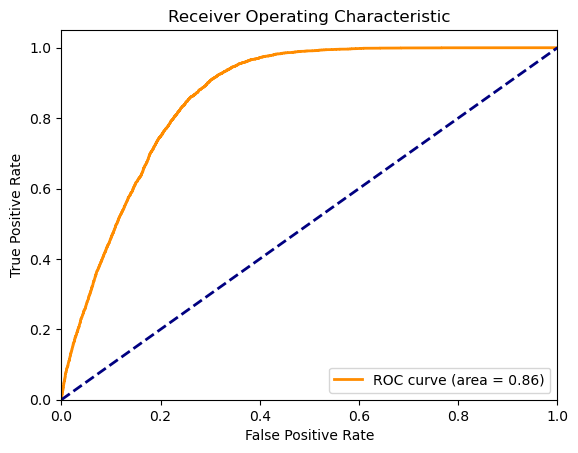

******************************************
Val 2
******************************************


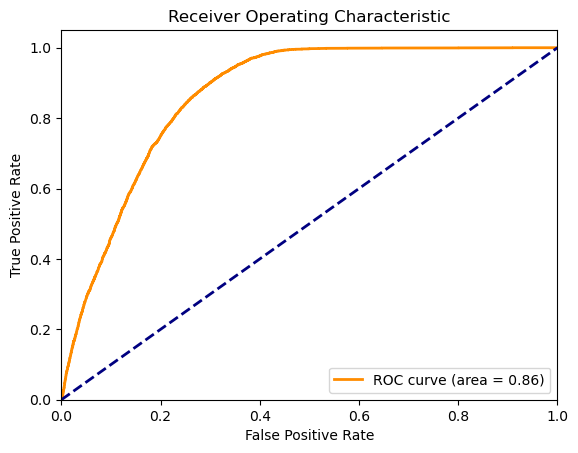

******************************************
Val Heart
******************************************


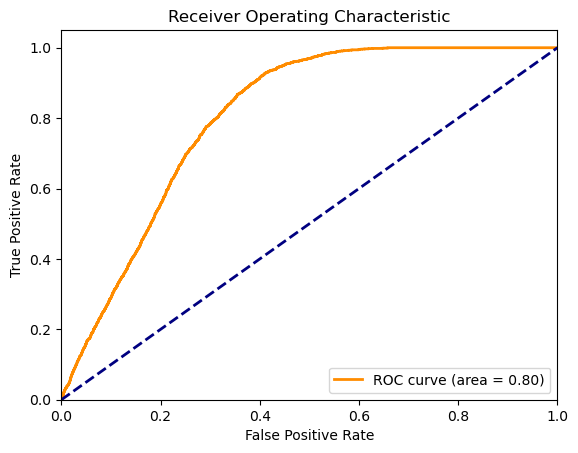

******************************************
Val HIV
******************************************


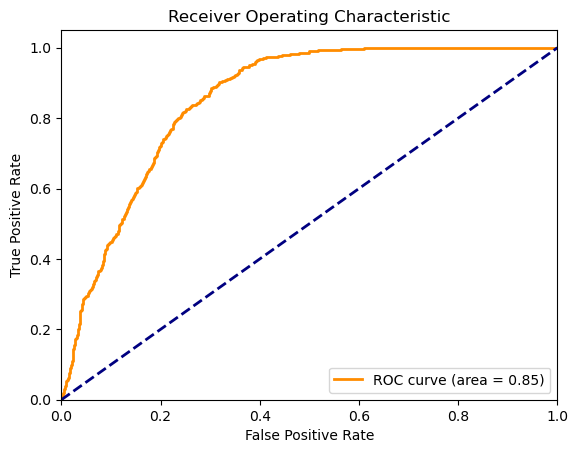

In [37]:
print("******************************************")
print("Val 1")
print("******************************************")
roc_analysis(val_1_pd, "Outputs", save = True)
print("******************************************")
print("Val 2")
print("******************************************")
roc_analysis(val_2_pd, "Outputs")
print("******************************************")
print("Val Heart")
print("******************************************")
roc_analysis(val_heart_set_pd, "Outputs")
print("******************************************")
print("Val HIV")
print("******************************************")
roc_analysis(val_HIV_set_pd, "Outputs")

In [38]:
def evaluate_cutoff(df, column, cutoff):
    df_tmp = df.copy()
    df_tmp["cutoff"] = (df_tmp[column] > cutoff)
    ct = pd.crosstab(df_tmp["Actual Labels"], df_tmp["cutoff"])
    
    print(ct)
    
    row_percentage = ct.div(ct.sum(axis = 1), axis = 0)
    
    print(row_percentage)
    


In [ ]:
#2.8%: 0.425; 3% 0.442.

In [39]:
k = 0.326

In [41]:
evaluate_cutoff(val_1_pd, "Outputs", k)

cutoff         False  True 
Actual Labels              
0.0            11402   1023
0.5             2002   7920
1.0              128   4417
cutoff            False     True 
Actual Labels                    
0.0            0.917666  0.082334
0.5            0.201774  0.798226
1.0            0.028163  0.971837


In [42]:
evaluate_cutoff(val_2_pd, "Outputs", k)

cutoff         False  True 
Actual Labels              
0.0            11686   1334
0.5             1738   7710
1.0               99   4484
cutoff            False     True 
Actual Labels                    
0.0            0.897542  0.102458
0.5            0.183954  0.816046
1.0            0.021602  0.978398


In [41]:
evaluate_cutoff(val_heart_set_pd, "Outputs", k)

cutoff         False  True 
Actual Labels              
0.0             6388    675
0.5             1913   7587
1.0               76   2430
cutoff            False     True 
Actual Labels                    
0.0            0.904432  0.095568
0.5            0.201368  0.798632
1.0            0.030327  0.969673


In [44]:
evaluate_cutoff(val_HIV_set_pd, "Outputs", k)

cutoff         False  True 
Actual Labels              
0.0             1955    375
0.5              537    954
1.0               48    531
cutoff            False     True 
Actual Labels                    
0.0            0.839056  0.160944
0.5            0.360161  0.639839
1.0            0.082902  0.917098


In [ ]:
def calculate_norm(df_relevance, output_column):
    df_tmp = df_relevance.copy()
    groups = [df1 for _, df1 in df_tmp.groupby("Objective")]
    for i in range(0, len(groups)):
        maximum = groups[i][output_column].max()
        minimum = groups[i][output_column].min()
        groups[i]["Normed relevance"] = (groups[i][output_column] - minimum)/(maximum - minimum)
        p95 = groups[i][output_column].quantile(0.95)
        p90 = groups[i][output_column].quantile(0.90)
        groups[i]["Normed relevance 95"] = (groups[i][output_column] - minimum)/(p95 - minimum)
        groups[i].loc[groups[i]["Normed relevance 95"] > 1, 'Normed relevance 95'] = 1 
        groups[i]["Normed relevance 90"] = (groups[i][output_column] - minimum)/(p90 - minimum)
        groups[i].loc[groups[i]["Normed relevance 90"] > 1, 'Normed relevance 90'] = 1
    df_norm = pd.concat(groups, ignore_index = True)
    return df_norm.copy()
    

In [ ]:
val_1_pd_n9095 = calculate_norm(val_1_pd, "Outputs")
val_2_pd_n9095 = calculate_norm(val_2_pd, "Outputs")
val_heart_pd_n9095 = calculate_norm(val_heart_set_pd, "Outputs")
val_HIV_pd_n9095 = calculate_norm(val_HIV_set_pd, "Outputs")

In [ ]:
len(val_heart_set_pd)

In [ ]:
print("******************************************")
print("Val 1")
print("******************************************")
roc_analysis(val_1_pd_n9095, "Normed relevance", save = True)
print("******************************************")
print("Val 2")
print("******************************************")
roc_analysis(val_2_pd_n9095, "Normed relevance")
print("******************************************")
print("Val Heart")
print("******************************************")
roc_analysis(val_heart_pd_n9095, "Normed relevance")
print("******************************************")
print("Val HIV")
print("******************************************")
roc_analysis(val_HIV_pd_n9095, "Normed relevance")

In [ ]:
evaluate_cutoff(val_1_pd_n9095, "Normed relevance", 0.566)

In [ ]:
evaluate_cutoff(val_2_pd_n9095, "Normed relevance", 0.566)

In [ ]:
evaluate_cutoff(val_heart_pd_n9095, "Normed relevance", 0.566)

In [ ]:
evaluate_cutoff(val_HIV_pd_n9095, "Normed relevance", 0.566)